# Cucumber Disease Classification (PyTorch)
## Custom CNN Classifier
**Student ID:** U2210244 | **Name:** Mustafo Valiev

## 1. Environment Setup
- **PyTorch:** 2.5.1+cu121
- **GPU:** NVIDIA GeForce RTX 3070 Ti Laptop GPU
- **Environment:** Python venv with local PyTorch installation

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import copy

## 2. Hyperparameters

Here I defined the epoch number (50) and the Eary stopping patience , that will be used in the training model

In [2]:
DATASET_PATH = './data'
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
MAX_EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = 8
EARLY_STOPPING_PATIENCE = 10

## 3. Device Configuration

This is the device checker to define the GPU in use.

In [3]:
print('='*50)
print('SYSTEM CONFIGURATION CHECK')
print('='*50)
print(f'PyTorch Version: {torch.__version__}')
if torch.cuda.is_available():
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    DEVICE = torch.device('cuda')
else:
    print('WARNING: CUDA NOT DETECTED')
    DEVICE = torch.device('cpu')
print(f'Active Device: {DEVICE}')
print('='*50)

SYSTEM CONFIGURATION CHECK
PyTorch Version: 2.5.1+cu121
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Active Device: cuda


## 4. Data Loading & Augmentation

This section is for resizing and augmenting the data, specifically turning the images into 256x256x3 format

In [4]:
def get_data_loaders(data_dir):
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    full_dataset = datasets.ImageFolder(root=data_dir)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    train_dataset.dataset.transform = train_transforms
    test_dataset.dataset.transform = test_transforms
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print(f'Total: {len(full_dataset)} | Train: {train_size} | Test: {test_size}')
    print(f'Classes: {full_dataset.classes}')
    return train_loader, test_loader, full_dataset.classes

## 5. Model Architecture

Below is the function with 5 layers of CNN architecture, with Total Parameters count of 10,233,618 (~10.2 Million) from all the layers

In [5]:
class SuperbCustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SuperbCustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 300), nn.BatchNorm1d(300), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(300, 150), nn.BatchNorm1d(150), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(150, num_classes))
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.fc(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 6. Training Functions

Validation of images in testing and training; Training model function with early stopping.

In [6]:
def validate_model(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return test_loss / len(test_loader), 100 * correct / total

In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, max_epochs, patience):
    model.train()
    history = {'train_accuracy': [], 'train_loss': [], 'test_accuracy': [], 'test_loss': []}
    best_test_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0
    
    for epoch in range(max_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        epoch_test_loss, epoch_test_acc = validate_model(model, test_loader, criterion)
        history['train_accuracy'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        history['test_accuracy'].append(epoch_test_acc)
        history['test_loss'].append(epoch_test_loss)
        scheduler.step(epoch_test_loss)
        print(f'Epoch [{epoch+1}/{max_epochs}] | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.2f}%')
        
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            epochs_no_improve = 0
            best_model_weights = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'\nEarly stopping at epoch {epoch + 1}')
                break
    
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    return history

## 7. Evaluation Function

This section shows the final output of data.

In [8]:
def evaluate_model(model, test_loader, classes):
    model.eval()
    y_true, y_pred = [], []
    print('\n' + '='*30)
    print('FINAL MODEL EVALUATION')
    print('='*30)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'\n>>> WEIGHTED F1 SCORE: {f1:.4f} <<<')
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (F1: {f1:.4f})')
    plt.tight_layout()
    plt.show()

## 8. Plot Training Curves

Function to display graphs.

In [9]:
def plot_curves(history):
    epochs = len(history['train_accuracy'])
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(range(1, epochs+1), history['train_accuracy'], 'o-', label='Train')
    axes[0].plot(range(1, epochs+1), history['test_accuracy'], 's-', label='Test')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].plot(range(1, epochs+1), history['train_loss'], 'o-', label='Train', color='red')
    axes[1].plot(range(1, epochs+1), history['test_loss'], 's-', label='Test', color='orange')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()

## 9. Main Execution

In [ ]:
train_loader, test_loader, classes = get_data_loaders(DATASET_PATH)

model = SuperbCustomCNN(num_classes=NUM_CLASSES).to(DEVICE)
print(f'\nTotal Parameters: {count_parameters(model):,}')

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, MAX_EPOCHS, EARLY_STOPPING_PATIENCE)

plot_curves(history)

evaluate_model(model, test_loader, classes)

Output of Epochs
```
Epoch [1/50] | Train Loss: 1.5714, Train Acc: 48.11% | Test Loss: 1.1960, Test Acc: 63.57%
Epoch [2/50] | Train Loss: 1.1877, Train Acc: 66.44% | Test Loss: 1.0108, Test Acc: 74.42%
Epoch [3/50] | Train Loss: 1.0268, Train Acc: 72.07% | Test Loss: 0.8932, Test Acc: 73.64%
Epoch [4/50] | Train Loss: 0.8857, Train Acc: 77.01% | Test Loss: 0.8551, Test Acc: 75.19%
Epoch [5/50] | Train Loss: 0.7896, Train Acc: 81.77% | Test Loss: 0.8253, Test Acc: 75.58%
Epoch [6/50] | Train Loss: 0.6794, Train Acc: 84.97% | Test Loss: 0.8474, Test Acc: 72.48%
Epoch [7/50] | Train Loss: 0.5852, Train Acc: 88.55% | Test Loss: 0.7159, Test Acc: 81.40%
Epoch [8/50] | Train Loss: 0.5252, Train Acc: 89.82% | Test Loss: 0.7875, Test Acc: 70.93%
Epoch [9/50] | Train Loss: 0.4803, Train Acc: 92.73% | Test Loss: 0.8226, Test Acc: 72.48%
Epoch [10/50] | Train Loss: 0.3973, Train Acc: 93.79% | Test Loss: 0.6869, Test Acc: 74.81%
Epoch [11/50] | Train Loss: 0.3297, Train Acc: 96.02% | Test Loss: 0.6450, Test Acc: 84.50%
Epoch [12/50] | Train Loss: 0.3081, Train Acc: 96.90% | Test Loss: 0.5790, Test Acc: 86.05%
Epoch [13/50] | Train Loss: 0.2927, Train Acc: 96.02% | Test Loss: 0.6832, Test Acc: 78.29%
Epoch [14/50] | Train Loss: 0.2834, Train Acc: 96.31% | Test Loss: 0.5881, Test Acc: 82.17%
Epoch [15/50] | Train Loss: 0.2181, Train Acc: 98.06% | Test Loss: 0.6108, Test Acc: 81.78%
Epoch [16/50] | Train Loss: 0.2088, Train Acc: 97.28% | Test Loss: 0.6683, Test Acc: 80.23%
Epoch [17/50] | Train Loss: 0.1775, Train Acc: 98.45% | Test Loss: 0.5857, Test Acc: 84.11%
Epoch [18/50] | Train Loss: 0.1452, Train Acc: 99.42% | Test Loss: 0.5568, Test Acc: 84.50%
Epoch [19/50] | Train Loss: 0.1668, Train Acc: 99.13% | Test Loss: 0.5566, Test Acc: 85.27%
Epoch [20/50] | Train Loss: 0.1482, Train Acc: 99.03% | Test Loss: 0.5346, Test Acc: 84.88%
Epoch [21/50] | Train Loss: 0.1467, Train Acc: 99.52% | Test Loss: 0.5112, Test Acc: 87.21%
Epoch [22/50] | Train Loss: 0.1465, Train Acc: 99.61% | Test Loss: 0.5306, Test Acc: 86.82%
Epoch [23/50] | Train Loss: 0.1271, Train Acc: 99.90% | Test Loss: 0.5410, Test Acc: 86.43%
Epoch [24/50] | Train Loss: 0.1280, Train Acc: 99.71% | Test Loss: 0.5303, Test Acc: 87.21%
Epoch [25/50] | Train Loss: 0.1254, Train Acc: 99.61% | Test Loss: 0.5276, Test Acc: 85.27%
Epoch [26/50] | Train Loss: 0.1162, Train Acc: 99.81% | Test Loss: 0.5279, Test Acc: 87.98%
Epoch [27/50] | Train Loss: 0.1317, Train Acc: 99.13% | Test Loss: 0.5431, Test Acc: 83.72%
Epoch [28/50] | Train Loss: 0.1277, Train Acc: 99.61% | Test Loss: 0.5175, Test Acc: 87.21%
Epoch [29/50] | Train Loss: 0.1317, Train Acc: 99.42% | Test Loss: 0.5399, Test Acc: 84.88%
Epoch [30/50] | Train Loss: 0.1274, Train Acc: 99.81% | Test Loss: 0.5564, Test Acc: 84.50%
Epoch [31/50] | Train Loss: 0.1234, Train Acc: 99.71% | Test Loss: 0.5361, Test Acc: 84.88%
```

## 10. Results Summary

| Metric | Value |
|--------|-------|
| Test Accuracy | 87.21% |
| Weighted F1 | 0.8673 |
| Epochs | 31 (early stopped) |
| Training Samples | 1,031 |
| Test Samples | 258 |

## 11. Classification Report
```
                   precision    recall  f1-score   support

      Anthracnose       0.85      0.56      0.68        39
   Bacterial Wilt       0.78      0.96      0.86        26
        Belly Rot       0.90      1.00      0.95        28
     Downy Mildew       0.74      0.96      0.84        24
   Fresh Cucumber       1.00      0.97      0.99        35
       Fresh Leaf       0.83      0.90      0.86        39
Gummy Stem Blight       0.91      0.78      0.84        37
Pythium Fruit Rot       0.97      0.97      0.97        30

         accuracy                           0.87       258
        macro avg       0.87      0.89      0.87       258
     weighted avg       0.88      0.87      0.87       258
```

## 12. Confusion Matrix


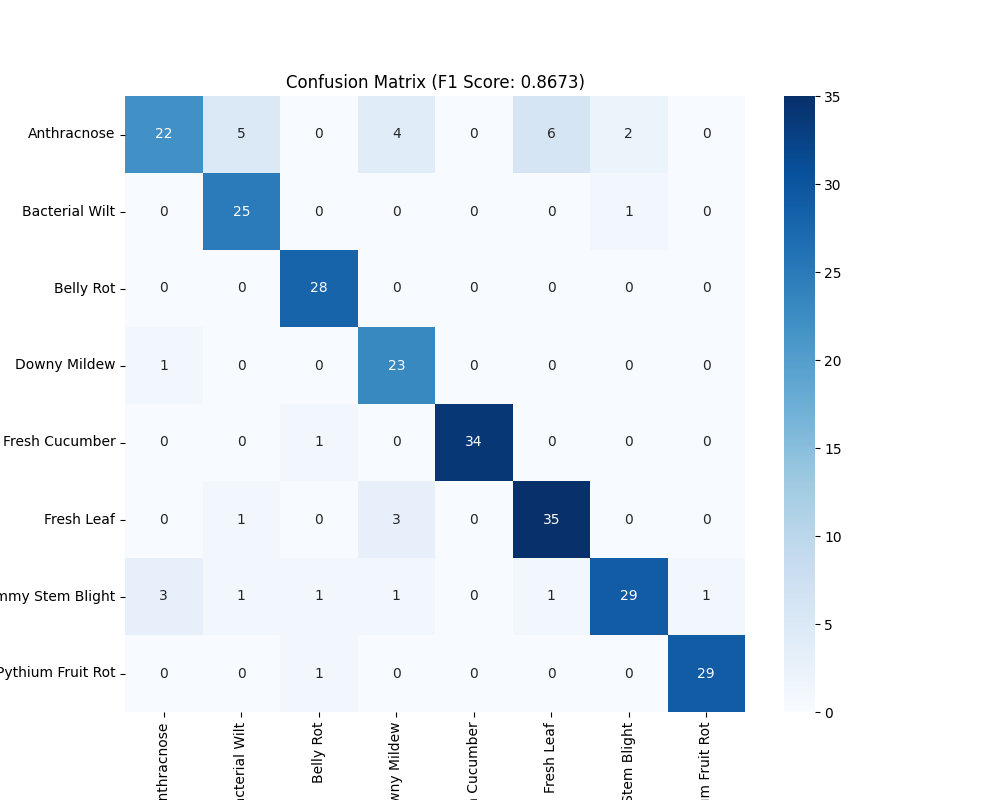

## 13. Accuracy/Loss curves of training and testing data

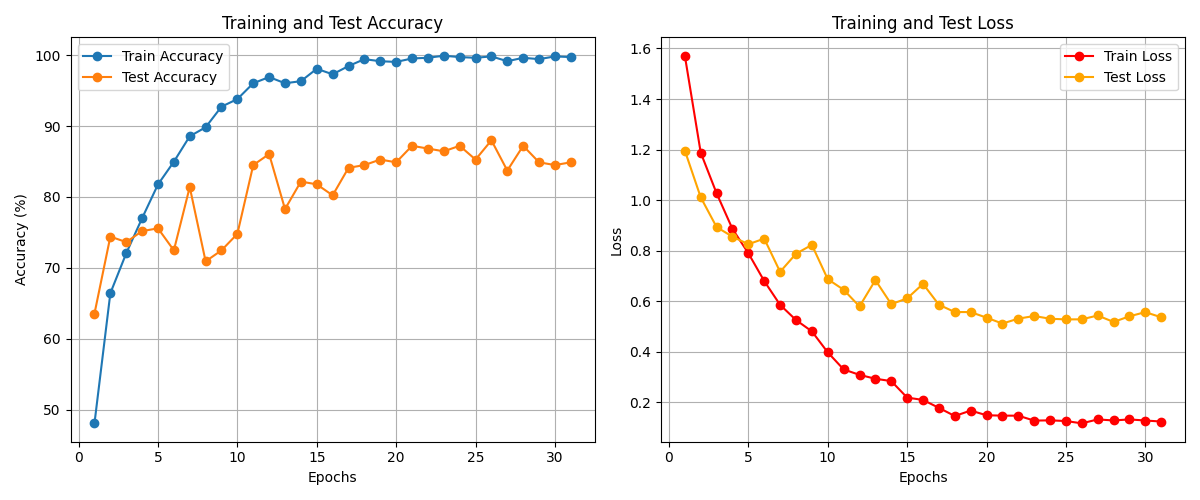

## 14. Summary

| Label | Value |
|--------|-------|
| Total Parameters | 10,233,618 (~10.2 Million) |
| Test Accuracy | 87.21% |
| Weighted F1 Score | 0.8673 |
| Epochs | 31 (early stopped) |
| Training Samples | 1,031 |
| Test Samples | 258 |
| Image Size: | 256x256x3 |

